# PART 1: Text-to-Image Generative Model as Zero-Shot Classifier

In [1]:
!pip install diffusers
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
from torch.nn import functional as F
from torchvision import datasets, transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.3 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Importing Dataset and Creating Pipeline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# All the classes of CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
# pipeline = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to(device)


cuda


100%|██████████| 170498071/170498071 [00:04<00:00, 39288091.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### STL-10 Datset

In [3]:
# from torchvision import datasets, transforms
# import torch
# from diffusers import StableDiffusionPipeline

# # STL-10 classes
# cifar10_classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# # STL-10 image preprocessing (resize STL-10 images from 96x96 to 512x512)
# transform = transforms.Compose([
#     # Resize to the input size expected by the model (512x512 for Stable Diffusion)
#     # transforms.Resize((512, 512)),
#     transforms.ToTensor()
# ])

# # Load STL-10 dataset with only labeled images
# cifar10_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)  # 'train' split for labeled training set
# cifar10_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

# # Load pre-trained Stable Diffusion pipeline
# pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")

# # Your classification code would remain the same, now using STL-10 images instead of CIFAR-10.


In [4]:
#print size of any image from dataset
print(cifar10_dataset[0][0].size())

torch.Size([3, 512, 512])


# The Architecture of Zero Shot Classification

In [7]:
def manual_mse(pred_latent, latent_image):

    assert pred_latent.shape == latent_image.shape, "Input tensors must have the same shape."

    squared_diffs = (pred_latent - latent_image) ** 2
    total_squared_diff = torch.sum(squared_diffs)
    mse = total_squared_diff / pred_latent.numel()  # Using numel to get the total number of elements

    return mse

total_timesteps = pipeline.scheduler.config.num_train_timesteps  # Accessing the totla timesteps of model

def compute_weight(t):
    #using -0.01 instead of -7 because -7 causes all the values go to 0
    return torch.exp(-0.01 * torch.tensor(t, dtype=torch.float32).to(device))

def diffusion_classification(image_tensor, categories, n_samples=50):
    # taking the image to latent space using VAE encoder
    latent_image = pipeline.vae.encode(image_tensor).latent_dist.sample()

    results = {category: 0 for category in categories}
    total_weights = 0

    for _ in tqdm(range(n_samples)):
        # as in paper , Sample a random timestep uniformly from [1, total_timesteps]
        t = torch.randint(1, total_timesteps, (1,), device=device).item()
        t_tensor = torch.tensor([t], device=device)

        weight = compute_weight(t)
        total_weights += weight.item() #for use in average below
        # print(weight)
        # print("   Timestep is: ", t)
        # tqdm.write(f"    Timestep is: {t}")
        # print("total timesteps: ", total_timesteps)

        for category in categories:
            category_prompt = f"A photo of a {category}"

            # Tokenizing the category prompt
            input_ids = pipeline.tokenizer(category_prompt, return_tensors="pt").input_ids.to(device)

            #Forward diffusion ----->>>add noise to the latent representation
            noisy_latent = pipeline.scheduler.add_noise(latent_image, torch.randn_like(latent_image), t_tensor)

            with torch.no_grad():
                # Prepare the text embeddings for conditioning
                # scaling_fac = 100
                text_embeddings = pipeline.text_encoder(input_ids).last_hidden_state
                # text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
                # text_embeddings = scaling_fac * text_embeddings

                #Nwo the Reverse diffusion (denoise) conditioned on the category using text embeddings
                pred_latent = pipeline.unet(noisy_latent, t_tensor, encoder_hidden_states=text_embeddings)["sample"]

                # generated_image_output = pipeline.vae.decode(pred_latent)
                # Extract the actual image tensor from the DecoderOutput
                # generated_image = generated_image_output.sample

            mse = manual_mse(pred_latent, latent_image)
            # print("category",category,"MSE",mse)
            # print("orig latent", latent_image)
            # print("pred_latent", pred_latent)

            # mse = F.mse_loss(generated_image, image_tensor)

            weighted_mse = mse.item() * weight.item()
            results[category] += weighted_mse

    for category in results:
            results[category] /= total_weights

    predicted_category = min(results, key=results.get)

    sorted_results = sorted(results.items(), key=lambda x: x[1])
    # Print the sorted results
    # for category, loss in sorted_results:
    #     print(f"Category: {category}, MSE Loss: {loss}")

    # Return the predicted category based on the minimum MSE loss
    predicted_category_n = sorted_results[0][0]  # This gets the category with the lowest loss
    # print(f"Predicted category: {predicted_category_n}")

    return predicted_category

## Testing and Image Plotting

100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


Predicted: deer, Ground Truth: ship


100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


Predicted: deer, Ground Truth: deer


100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


Predicted: horse, Ground Truth: automobile


100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


Predicted: deer, Ground Truth: frog


100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


Predicted: deer, Ground Truth: cat


100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


Predicted: dog, Ground Truth: automobile


100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


Predicted: deer, Ground Truth: airplane


100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


Predicted: truck, Ground Truth: horse


100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


Predicted: bird, Ground Truth: horse


100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


Predicted: deer, Ground Truth: airplane
Accuracy: 10.00%


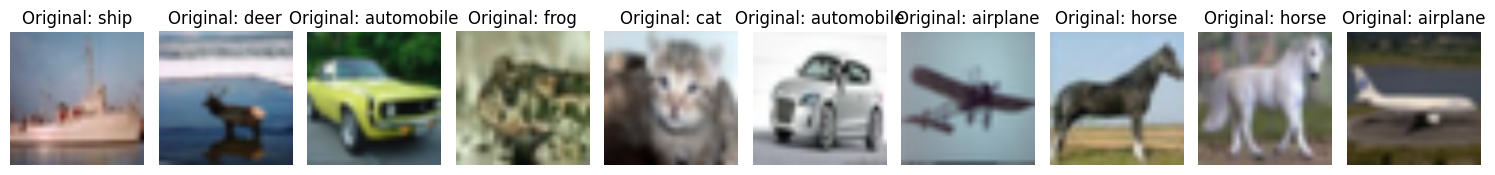

In [8]:
import matplotlib.pyplot as plt

num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
original_classes = []
predicted_classes = []

for batch_idx, (image, label) in enumerate(cifar10_loader):
    if batch_idx >= num_images_to_display:
        break

    image = image.to("cuda")
    original_class = cifar10_classes[label.item()]

    predicted_class = diffusion_classification(image, cifar10_classes)

    original_classes.append(original_class)
    predicted_classes.append(predicted_class)

    print(f"Predicted: {predicted_class}, Ground Truth: {original_class}")

    image_display = image[0].cpu().permute(1, 2, 0).numpy()
    image_display = (image_display * 255).astype(np.uint8)  # Scale to [0, 255]

    axes[batch_idx].imshow(image_display)
    axes[batch_idx].set_title(f"Original: {original_class}")
    axes[batch_idx].axis('off')

correct_predictions = sum(1 for original, predicted in zip(original_classes, predicted_classes) if original == predicted)
total_predictions = len(original_classes)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# Show the images
plt.tight_layout()
plt.show()

In [9]:
def predict_image_category(image_filepath, categories, device="cuda"):

    image = Image.open(image_filepath).convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])

    image_tensor = preprocess(image).unsqueeze(0).to(device)

    predicted_class = diffusion_classification(image_tensor, categories)

    return predicted_class

image_filepath = "/content/Car.jpeg"
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predicted_category = predict_image_category(image_filepath, categories)
print(f"Predicted Category: {predicted_category}")


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]

Predicted Category: dog
